# Setup & Imports

In [25]:
import importlib

import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import constants.features_constants as features_constants
import data_io
import pipelines.training as training
from constants.modell_constants import TEST_SIZE, RANDOM_STATE
from pipelines import preprocessing
from pipelines.preprocessing import build_preprocessor, feature_to_category, \
  feature_to_fp32
from viz import (plot_residual_heatmap, plot_residual_distribution,
                 ensure_predictions_and_residuals,plot_residual_scatter,show_corr_matrix)

importlib.reload(features_constants)
importlib.reload(preprocessing)
importlib.reload(training)

<module 'pipelines.training' from '/Users/Wendo99/Documents/50-Apps/PyCharm/NYC_Taxi/src/pipelines/training.py'>

In [4]:
df = data_io.load_taxi_weather_data()

df = df.loc[~df[features_constants.INVALID_COLS].any(axis=1)].copy()
df = df.drop(columns=[c for c in df.columns if c in features_constants.DROPPED_FEATURES])
df = feature_to_fp32(df, features_constants.NUM_ALL)
df = feature_to_category(df, features_constants.CAT_ALL)
x_dataset = df.drop(columns=[features_constants.TARGET])
y_dataset = df[features_constants.TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    x_dataset, y_dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Preprocessing-Configuration

In [5]:
preprocessor = build_preprocessor()

## Hyperparameter Search

In [6]:
NEED_SEARCH = True
NO_SEARCH = False

Ridge

In [7]:
if NO_SEARCH:
  training.search_hyperparameters("Ridge", preprocessor, x_train, y_train, 5)

Random Forest

In [8]:
if NO_SEARCH:
  training.search_hyperparameters("RandomForest", x_train, y_train, 4)

XGBoost

In [9]:
if NO_SEARCH:
  training.search_hyperparameters("XGBoost", preprocessor, x_train, y_train, 50)

Bayes

In [10]:
if NO_SEARCH:
  training.search_hyperparameters("Bayes", x_train, y_train, 6)

SVM

In [11]:
if NO_SEARCH:
  training.search_hyperparameters("SVM", x_train, y_train, 10)

# First Train

In [12]:
RETRAIN = False
TRAIN = True
NO_TRAIN = False

In [13]:
if NO_TRAIN:
  linReg = training.fit_save_model("LinearRegression", preprocessor, x_train, y_train,
                                   retrain=RETRAIN)

In [14]:
if NO_TRAIN:
  ridge = training.fit_save_model("Ridge", preprocessor, x_train, y_train, retrain=RETRAIN)

In [15]:
if NO_TRAIN:
  random_forest = training.fit_save_model("RandomForest", preprocessor, x_train, y_train,
                                          retrain=RETRAIN)

In [16]:
if NO_TRAIN:
  bayes = training.fit_save_model("Bayes", preprocessor, x_train, y_train, retrain=RETRAIN)

In [17]:
if TRAIN:
  xgboost = training.fit_save_model("XGBoost", preprocessor, x_train, y_train, retrain=RETRAIN)

# CV Performance Search

In [18]:
CV_TRAIN = True
NO_CV = False

Lin Reg

In [19]:
if NO_CV:
  training.cv_train('LinearRegression', linReg, x_train, y_train)

Ridge

In [20]:
if NO_CV:
  training.cv_train('Ridge', ridge, x_train, y_train)

RF

In [21]:
if NO_CV:
  training.cv_train('RandomForest', random_forest, x_train, y_train)

Bayes

In [22]:
if NO_CV:
  training.cv_train('Bayes', bayes, x_train, y_train)

XGBoost

In [23]:
if NO_CV:
  training.cv_train('XGBoost', xgboost, x_train, y_train)

In [29]:
X_full = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

xgboost.fit(x_test, y_test)

# optional: evaluate on a holdout or print training error
preds_test = xgboost.predict(x_test)
print("Score – Testset RMSE:", root_mean_squared_error(y_test, preds_test))


Score – Testset RMSE: 0.3095351756435031


# Top Features

In [33]:
SHOW_TOP_F = True
NO_SHOW = False

Linear Regression

In [ ]:
# if NO_SHOW:
#   top20 = training.top_linreg_features(linReg, x_train=x_train, top_n=20)
#   print(top20)

Ridge

In [ ]:
# if NO_SHOW:
#   top20 = training.top_linreg_features(ridge_fixed, x_train=x_train, top_n=40)
#   print(top20)

Random Forest

In [ ]:
# if NO_SHOW:
#   top20_rf = training.top_tree_features(random_forest, x_train=x_train, top_n=20)
#   print(top20_rf)

Bayes Net

In [ ]:
# if NO_SHOW:
#   top20_bayes = training.top_generic_features(bayes, x_train=x_train, y_train=y_train, top_n=20
#                                               )
#   print(top20_bayes)

XGBoost

In [34]:
if SHOW_TOP_F:
  top20_xgb = training.top_tree_features(xgboost, x_train=x_train, top_n=40)
  print(top20_xgb)

                  feature  importance  rel_importance  cum_importance
0   route_distance_log_km    0.383431       38.459999       38.459999
1         hav_dist_km_log    0.168698       16.920000       55.389999
2        pickup_cluster_2    0.044032        4.420000       59.799999
3        pickup_cluster_0    0.030340        3.040000       62.849998
4             hour_of_day    0.028181        2.830000       65.680000
5        is_early_morning    0.023776        2.390000       68.059998
6          pickup_weekday    0.018548        1.860000       69.919998
7        dropoff_latitude    0.017810        1.790000       71.709999
8                is_night    0.017558        1.760000       73.470001
9        pickup_cluster_4    0.017481        1.750000       75.220001
10      dropoff_cluster_8    0.014467        1.450000       76.669998
11             is_holiday    0.014218        1.430000       78.099998
12      dropoff_cluster_4    0.013378        1.340000       79.440002
13       pickup_long

# Error Analysis

In [30]:
model_name = "XGBoost"
model = xgboost

In [31]:
df_err = training.get_res_errors(modell=model, x_train=x_train,
                                 y_train=y_train)

✅ Saved residual distribution to ../figures/xgb_residual_distribution.png


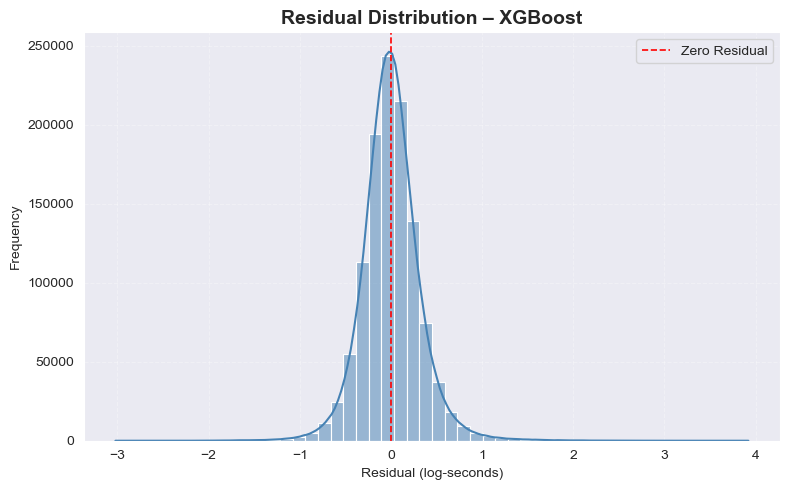

In [35]:
plot_residual_distribution(df_err, "XGBoost",
                           save_path="../figures/xgb_residual_distribution.png")

In [ ]:
df_err = ensure_predictions_and_residuals(df_err, model, x_train, y_train)

plot_residual_scatter(df_err, "XGBoost",
                      save_path="../figures/xgb_residual_scatter.png")

In [ ]:
training.list_res_errors(df_err, model_name)

In [ ]:
df_err['dist_bin'] = pd.qcut(
    df_err['route_distance_log_km'].fillna(0),
    q=10,
    labels=False
)

plot_residual_heatmap(df_err, "XGBoost",
                      x_col='dist_bin',
                      y_col='hour_of_day',
                      save_path="../figures/xgb_residual_heatmap.png")

In [ ]:
training.list_errors_10_bins(df_err, model_name, "hav_dist_km_log")

In [ ]:
training.list_errors_10_bins(df_err, model_name, "route_distance_log_km")

# Feature eng / selection

In [36]:
corr = x_train.corr()

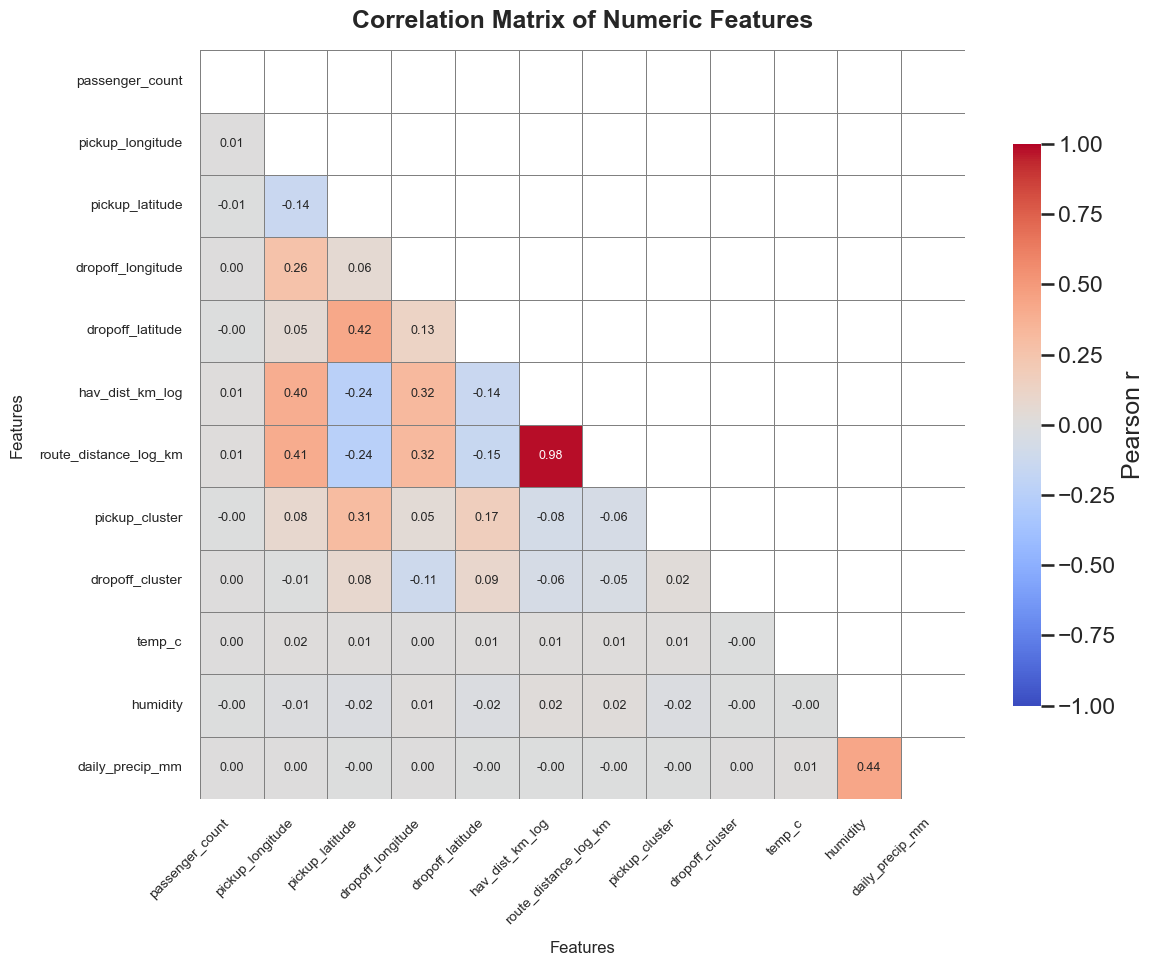

In [39]:
num = x_train.select_dtypes("number")
corr = num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

show_corr_matrix(mask=mask,corr=corr)

In [37]:
hi_corr = (corr.abs()
           .stack()
           .rename("corr")
           .reset_index()
           .query("level_0 < level_1 and corr >= 0.70")
           .sort_values("corr", ascending=False))
print(hi_corr.head(20))

             level_0                level_1      corr
190  hav_dist_km_log  route_distance_log_km  0.982592
491           temp_c              temp_code  0.878559
278     pickup_month                 temp_c  0.775675
283     pickup_month              temp_code  0.719833


In [ ]:
rank = (
  x_train.assign(target=y_train)
  .corr()
  ["target"]
  .abs()
  .sort_values(ascending=False)
)
print(rank.head(20))